In [10]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

#Algorithms
from sklearn import ensemble, linear_model
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

# Model
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import VotingClassifier

# permutation_importance
from sklearn.inspection import permutation_importance

from scipy import stats

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import ShuffleSplit

from sklearn.pipeline import Pipeline

from sklearn.utils.class_weight import compute_sample_weight

In [26]:
w = len(y) / (2 * np.bincount(y_in_train))

In [2]:
data = pd.read_csv('year_train.csv')
X = data.drop(columns=['year','pol_id', 'STATE_x','ZIP5_x','ZIP4_x','no_hit_x','Unnamed: 0','Unnamed: 0.1','STATE_y','ZIP5_y','ZIP4_y','no_hit_y'])
y = data['no_hit_x']

In [5]:
def spearman(x):
    return abs(stats.spearmanr(x,y)[0])
def spear_imp(data):
    spearman_importance = data.apply(spearman).sort_values()
    return spearman_importance
importance = spear_imp(X)

In [4]:
X_n = X.drop(columns=importance.index[0:400])

In [6]:
#loading original test set
test_in = pd.read_csv('C:/Users/94018/Documents/BA886-7(2)/New folder/y_test_data.csv')
test_in.head()
X_in_test = test_in.drop(columns=['year','pol_id', 'STATE','ZIP5','ZIP4','no_hit']).drop(columns=importance.index[0:400])
y_in_act = test_in['no_hit']

In [7]:
#loading original train set
train_in = pd.read_csv('C:/Users/94018/Documents/BA886-7(2)/New folder/year_train_data.csv')
train_in.head()
X_in_train = train_in.drop(columns=['year','pol_id', 'STATE','ZIP5','ZIP4','no_hit']).drop(columns=importance.index[0:400])
y_in_train = train_in['no_hit']

In [7]:
best_params = [{'ridgeclassifier__solver': 'auto',
  'ridgeclassifier__fit_intercept': True,
  'ridgeclassifier__class_weight': None,
  'ridgeclassifier__alpha': 0.01},
 {'randomforestclassifier__n_estimators': 95,
  'randomforestclassifier__min_samples_split': 3,
  'randomforestclassifier__min_samples_leaf': 1,
  'randomforestclassifier__max_features': 'sqrt',
  'randomforestclassifier__max_depth': 28,
  'randomforestclassifier__class_weight': 'balanced'},
 {'extratrees__warm_start': False,
  'extratrees__n_estimators': 500,
  'extratrees__min_samples_split': 5,
  'extratrees__min_samples_leaf': 2,
  'extratrees__max_features': 'auto',
  'extratrees__max_depth': None,
  'extratrees__class_weight': None},
 {'xgbclassifier__subsample': 0.7000000000000002,
  'xgbclassifier__sampling_method': 'uniform',
  'xgbclassifier__max_depth': 26,
  'xgbclassifier__gamma': 3,
  'xgbclassifier__eta': 0.1,
  'xgbclassifier__booster': 'gbtree'}]

In [8]:
def get_voting():
	# define the base models
    models = list()
    
    models.append(('XGB_0',xgb.XGBClassifier(subsample=best_params[3].get('xgbclassifier__subsample'),
                    sampling_method=best_params[3].get('xgbclassifier__sampling_method'),
                    max_depth=best_params[3].get('xgbclassifier__max_depth'),
                    gamma=best_params[3].get('xgbclassifier__gamma'),
                    eta=best_params[3].get('xgbclassifier__eta'),
                    booster=best_params[3].get('xgbclassifier__booster'),
                    random_state=0)))
    models.append(('XGB_1',xgb.XGBClassifier(subsample=best_params[3].get('xgbclassifier__subsample'),
                    sampling_method=best_params[3].get('xgbclassifier__sampling_method'),
                    max_depth=best_params[3].get('xgbclassifier__max_depth'),
                    gamma=best_params[3].get('xgbclassifier__gamma'),
                    eta=best_params[3].get('xgbclassifier__eta'),
                    booster=best_params[3].get('xgbclassifier__booster'),
                    random_state=1)))
    models.append(('XGB_2',xgb.XGBClassifier(subsample=best_params[3].get('xgbclassifier__subsample'),
                    sampling_method=best_params[3].get('xgbclassifier__sampling_method'),
                    max_depth=best_params[3].get('xgbclassifier__max_depth'),
                    gamma=best_params[3].get('xgbclassifier__gamma'),
                    eta=best_params[3].get('xgbclassifier__eta'),
                    booster=best_params[3].get('xgbclassifier__booster'),
                    random_state=2)))
    models.append(('XGB_3',xgb.XGBClassifier(subsample=best_params[3].get('xgbclassifier__subsample'),
                    sampling_method=best_params[3].get('xgbclassifier__sampling_method'),
                    max_depth=best_params[3].get('xgbclassifier__max_depth'),
                    gamma=best_params[3].get('xgbclassifier__gamma'),
                    eta=best_params[3].get('xgbclassifier__eta'),
                    booster=best_params[3].get('xgbclassifier__booster'),
                    random_state=3)))
   
	# define the voting ensemble
    vot = VotingClassifier(estimators=models, voting='soft',flatten_transform=False)
    return vot

def evaluate_model(model,X_n,X_t_t,y):
    model.fit(X_n,y)
    pred = model.predict(X_t_t)
    auc = roc_auc_score(y_t,pred)
    return auc

## insample ensemble

In [9]:
# fit the model and get probability for each data point
model = get_voting()
model.fit(X_n,y)
p_in = model.transform(X_in_test)

C:\Users\94018\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:28:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:29:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:32:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\94018\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [10]:
p_t = sum(p_in)/4

In [11]:
positive,negative = list(),list()
for i in p_t:
    positive.append(i[1])
    negative.append(i[0])

In [12]:
lift_in = pd.DataFrame()
lift_in['actual'] = y_in_act
lift_in['positive'] = positive
lift_in['negative'] = negative

In [13]:
# lift_in.to_csv('insample.csv')

In [14]:
# lift_in = pd.read_csv('insample.csv')

In [15]:
lift_in = lift_in.sort_values(by = 'positive')

In [16]:
pred,act,pb = list(),list(),list()
n = len(lift_in)
n_group = 40
for i in range(n_group):
    a = np.mean(lift_in['actual'][int(n*i/n_group):int(n*(i+1)/n_group)])
    b = np.mean(lift_in['positive'][int(n*i/n_group):int(n*(i+1)/n_group)])
    act.append(a)
    pb.append(b)

In [17]:
lift_chart_in = pd.DataFrame({'act':act,'prob':pb})
lift_chart_in

,act,prob
0,0.017810,0.025715
1,0.016480,0.036741
2,0.013184,0.044161
3,0.013852,0.050889
4,0.021094,0.057380
5,0.021094,0.064005
6,0.024390,0.070772
7,0.018470,0.077558
8,0.019776,0.084451
9,0.028345,0.091689


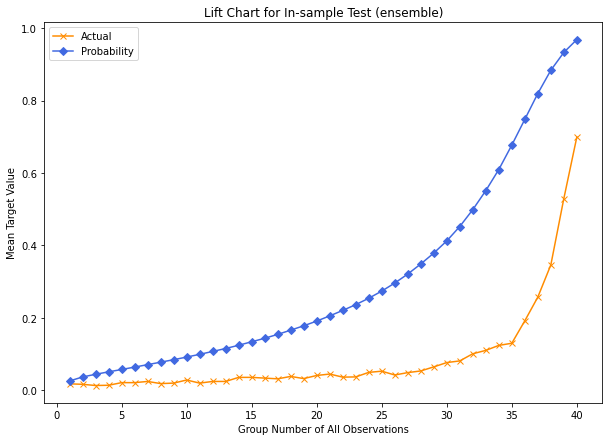

In [18]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(range(n_group+1)[1:], lift_chart_in['act'], label='Actual', color='darkorange', marker='x')
plt.plot(range(n_group+1)[1:], lift_chart_in['prob'], label='Probability', color='royalblue', marker='D')
plt.title('Lift Chart for In-sample Test (ensemble)')
plt.xlabel('Group Number of All Observations')
plt.ylabel('Mean Target Value')
plt.legend()
plt.show()

## outsample ensemble

In [19]:
#loading outsample test set
test_out = pd.read_csv('C:/Users/94018/Documents/BA886-7(2)/New folder (3)/year_outsample.csv')
X_out_test = test_out.drop(columns=['no_hit','Unnamed: 0']).drop(columns=importance.index[0:400])
y_out_act = test_out['no_hit']

In [20]:
model = get_voting()
model.fit(X_n,y)
p_out = model.transform(X_out_test)

C:\Users\94018\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:34:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:35:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:37:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:38:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\94018\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [21]:
p_o = sum(p_out)/4

In [22]:
positive_o,negative_o = list(),list()
for i in p_o:
    positive_o.append(i[1])
    negative_o.append(i[0])

In [23]:
lift_out = pd.DataFrame()
lift_out['actual_o'] = y_out_act
lift_out['positive_o'] = positive_o
lift_out['negative_o'] = negative_o

In [24]:
# lift_out.to_csv('outsample.csv')

In [25]:
# lift_out = pd.read_csv('outsample.csv')

In [26]:
lift_out = lift_out.sort_values(by = 'positive_o')

In [27]:
pred_o,act_o,pb_o = list(),list(),list()
n = len(lift_out)
n_group_o = 40
for i in range(n_group):
    a = np.mean(lift_out['actual_o'][int(n*i/n_group_o):int(n*(i+1)/n_group_o)])
    b = np.mean(lift_out['positive_o'][int(n*i/n_group_o):int(n*(i+1)/n_group_o)])
    act_o.append(a)
    pb_o.append(b)

In [28]:
lift_chart_out = pd.DataFrame({'act_o':act_o,'prob_o':pb_o})
lift_chart_out

,act_o,prob_o
0,0.048453,0.034492
1,0.041938,0.047465
2,0.043160,0.056815
3,0.041531,0.065121
4,0.048026,0.072977
5,0.046824,0.081078
6,0.055375,0.089201
7,0.054967,0.097489
8,0.054967,0.106154
9,0.059015,0.114791


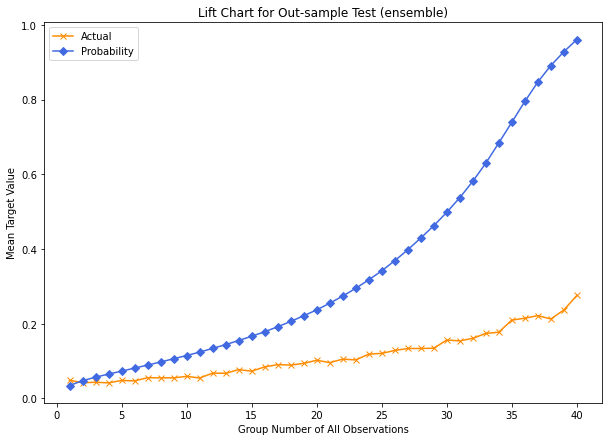

In [29]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(range(n_group_o+1)[1:], lift_chart_out['act_o'], label='Actual', color='darkorange', marker='x')
plt.plot(range(n_group_o+1)[1:], lift_chart_out['prob_o'], label='Probability', color='royalblue', marker='D')
plt.title('Lift Chart for Out-sample Test (ensemble)')
plt.xlabel('Group Number of All Observations')
plt.ylabel('Mean Target Value')
plt.legend()
plt.show()

In [11]:
lift_out.head()

,Unnamed: 0,actual_o,positive_o,negative_o
0,0,0,0.012737,0.987263
1,1,0,0.022177,0.977823
2,2,0,0.014534,0.985466
3,3,1,0.054149,0.945851
4,4,0,0.021127,0.978873


In [17]:
lift_in['pred'] = np.where(lift_in['positive']>0.5,1,0)

In [19]:
roc_auc_score(lift_out['actual_o'],lift_out['pred'])

0.520235903579851

In [48]:
t_in = test_in.drop(columns=['year','pol_id', 'STATE','ZIP5','ZIP4']).drop(columns=importance.index[0:400])

In [ ]:
t_in.head()

In [52]:
t_in.describe()

,no_hit,var0011,var0011_ind,var0012,var0012_ind,var0013,var0013_ind,var0014,var0014_ind,var0020,...,var1247_ind,var1254,var1254_ind,var1267,var1271,var1271_ind,var1272,var1272_ind,var1284,var1284_ind
count,60669.000000,60669.000000,60669.000000,60669.000000,60669.000000,60669.000000,60669.000000,60669.000000,60669.000000,60669.000000,...,60669.000000,60669.000000,60669.000000,60669.000000,60669.000000,60669.000000,60669.000000,60669.000000,60669.000000,60669.000000
mean,0.089667,10.203399,0.159307,1.344093,0.229837,1.231546,0.286637,2003.674760,0.194449,1.298509,...,0.022647,30.446430,0.023785,-222.492855,30.005697,0.023455,30.008841,0.023241,30.034332,0.028285
std,0.285706,5.208791,0.365965,0.767538,0.420732,0.529345,0.452194,10.467455,0.395779,0.684326,...,0.148778,0.335721,0.152379,652.146943,0.019049,0.151345,0.018843,0.150669,0.029615,0.165786
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1944.000000,0.000000,0.000000,...,0.000000,28.805121,0.000000,-2721.000000,29.954777,0.000000,29.944776,0.000000,29.862468,0.000000
25%,0.000000,6.000000,0.000000,1.681834,0.000000,0.974838,0.000000,1999.000000,0.000000,1.539401,...,0.000000,30.412578,0.000000,-161.000000,29.990903,0.000000,29.993567,0.000000,30.014849,0.000000
50%,0.000000,12.000000,0.000000,1.721898,0.000000,1.457108,0.000000,2005.000000,0.000000,1.644403,...,0.000000,30.553707,0.000000,-79.000000,30.002576,0.000000,30.004530,0.000000,30.036486,0.000000
75%,0.000000,15.000000,0.000000,1.863989,0.000000,1.624731,1.000000,2011.000000,0.000000,1.694222,...,0.000000,30.651443,0.000000,-12.000000,30.022603,0.000000,30.025452,0.000000,30.053371,0.000000
max,1.000000,15.000000,1.000000,1.930718,1.000000,1.753894,1.000000,2018.000000,1.000000,1.792798,...,1.000000,30.831617,1.000000,1709.000000,30.074353,1.000000,30.074353,1.000000,30.150854,1.000000


In [49]:
t_out = test_out.drop(columns=['Unnamed: 0']).drop(columns=importance.index[0:400])

In [ ]:
t_out.head()

In [53]:
t_out.describe()

,no_hit,var0011,var0011_ind,var0012,var0012_ind,var0013,var0013_ind,var0014,var0014_ind,var0020,...,var1247_ind,var1254,var1254_ind,var1267,var1271,var1271_ind,var1272,var1272_ind,var1284,var1284_ind
count,98248.000000,98248.000000,98248.000000,98248.000000,98248.000000,98248.000000,98248.000000,98248.000000,98248.000000,98248.000000,...,98248.000000,98248.000000,98248.000000,98248.000000,98248.000000,98248.000000,98248.000000,98248.000000,98248.000000,98248.000000
mean,0.113946,10.112420,0.185978,1.285474,0.158436,1.173901,0.220697,2004.473160,0.251924,1.250220,...,0.044947,30.354332,0.063838,-359.589345,30.000933,0.042108,30.005582,0.041802,30.022242,0.100389
std,0.317748,5.143578,0.389091,0.766333,0.365151,0.571262,0.414718,9.707837,0.434120,0.682685,...,0.207190,0.334052,0.244466,926.262142,0.019774,0.200836,0.017998,0.200138,0.032172,0.300519
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1944.000000,0.000000,0.000000,...,0.000000,28.937825,0.000000,-2721.000000,29.955619,0.000000,29.944776,0.000000,29.862468,0.000000
25%,0.000000,5.000000,0.000000,0.000000,0.000000,0.701557,0.000000,2001.000000,0.000000,1.531532,...,0.000000,30.182982,0.000000,-222.000000,29.984213,0.000000,29.989515,0.000000,30.010119,0.000000
50%,0.000000,12.000000,0.000000,1.705242,0.000000,1.457108,0.000000,2005.000000,0.000000,1.644403,...,0.000000,30.469546,0.000000,-69.000000,30.001843,0.000000,30.006026,0.000000,30.027820,0.000000
75%,0.000000,15.000000,0.000000,1.721898,0.000000,1.618828,0.000000,2012.000000,1.000000,1.644403,...,0.000000,30.586190,0.000000,14.000000,30.012721,0.000000,30.015497,0.000000,30.038349,0.000000
max,1.000000,15.000000,1.000000,1.930718,1.000000,1.753894,1.000000,2018.000000,1.000000,1.792798,...,1.000000,30.831617,1.000000,1717.000000,30.083403,1.000000,30.074860,1.000000,30.128932,1.000000
